### Machine Learning Group Project


### Teammembers and Contribution

Wong Tung Tung 56221080 
- designed Model XY

Ferris ML: Ng Cheuk Fai 55818427 
- designed Model XY

Dario Bogenreiter 40143681 
- wrote Step 0.1 0.2.1, 0.2.2, 0.2.3
- wrote Step 1
- wrote Step 2
- wrote Step 3.2.1, 3.2.2
- designed the structure of the notebook

# Step 0. Prereqesites

## 0.1 Load necessary libraries

In [ ]:
import regex as re
re.sub("\d+", "original", ("055".split("_")[0]))

'original'

In [ ]:
%%capture

# standard libraries
import pandas as pd
import numpy as np
from numpy import *
import sys

# for visuals
import matplotlib.pyplot as plt 
import matplotlib

# handling files
import zipfile
import os
import fnmatch
import regex as re

# dealing with images
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import skimage
import cv2
from skimage import img_as_ubyte
from PIL import Image
from sklearn import *
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean

#for cleaning up memory
import gc

#for deleting files
import shutil

#for shuffeling the data
import random
from sklearn.utils import shuffle

#for model visuals
!pip install visualkeras
import visualkeras

#for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.layers.serialization import populate_deserializable_objects

In [ ]:
#note I had to run the file on google colab since my processor was too weak
from google.colab import drive

#connect to google drive
drive.mount("/content/gdrive", force_remount=True)
%cd gdrive/My\ Drive/Colab_Notebooks/ML/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab_Notebooks/ML


## 0.2 Defining functions

### 0.2.1. Data Loading function

In [83]:
def create_data_split_and_directory(train_val_test_split = (0.8, 0.1, 0.1), extract_zip=False):
    """ The following takes the orignal data from a zip or a folder
    and creates approciates directory strucutre with files
    given a split """

    # unzip the orignal data into directory if not already done
    if extract_zip:
      if 'unzipped_data' in os.listdir():
        shutil.rmtree('./unzipped_data/')
      with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
          zip_ref.extractall('./unzipped_data/')
    else:
      pass

    # create data structure
    # delete previous data folder if there was
    # already one earlier, enables us to create new splits easily
    if 'data' in os.listdir():
      shutil.rmtree('./data/')
    # create the folders 
    os.mkdir('./data/')
    os.mkdir('./data/train/')
    os.mkdir('./data/val/')
    os.mkdir('./data/test/')
    # for all subsets create folders to store the label information
    for sub_directory in os.listdir('./data/'):
      os.mkdir('./data/' + sub_directory + '/original/')
      os.mkdir('./data/' + sub_directory + '/manipulated/')

    # open all file names from original data
    all_manipulated_files = []
    all_original_files = []
    for path, subdir, files in os.walk('./unzipped_data/data/'):
        for name in files:
              if fnmatch.fnmatch(name, "*.png"):
                  if "original" in path:
                      all_original_files.append(os.path.join(path, name))
                  elif "manipulated" in path:
                      all_manipulated_files.append(os.path.join(path, name))

    # shuffle the data
    random.shuffle(all_original_files)
    random.shuffle(all_manipulated_files)

    # split the data by moving it into a new directory
    # the try loops are just a precaustion in case
    # we can not evenly split the data
    sub_set_num = 0
    num_all_manipulated = int(len(all_manipulated_files))
    num_all_originals = int(len(all_original_files))
    for data_sub_set in ['train', 'val', 'test']:
      s_to_move = int(num_all_manipulated*train_val_test_split[sub_set_num])
      for file in all_manipulated_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/manipulated/') 
        except:
          print(file)
          pass
      all_manipulated_files = all_manipulated_files[s_to_move:]
      
      s_to_move = int(num_all_originals*train_val_test_split[sub_set_num])
      for file in all_original_files[0:s_to_move]:
        try:
          shutil.copy(file, './data/' + data_sub_set + '/original/')
        except:
          print(file)
          pass
      all_original_files = all_original_files[s_to_move:]

      sub_set_num = sub_set_num + 1

def load_color_image(path, imagesize):
    """ simple function
    to open an image from path as color image"""
    # open file
    image = cv2.imread(path)
    # change color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # change size
    image = cv2.resize(image, imagesize)
    return image

def load_bw_image(path, imagesize):
    """ simple function
    to open an image from path as black and white image"""
    # parse it as image
    sk_image = skimage.io.imread(path)
    # parse image as bw image and change size of bw image
    sk_bw_image = skimage.io.imread(zfile.open(name), as_gray=True)
    image = resize(sk_bw_image, imagesize, anti_aliasing=True)
    return image
      
def load_data(imagesize, path = './data/', bw = False):
    """
    The main functionality to load images as numpy array given a datapath
    Paramater imagesize is a 1x2 array indicating how big the
    loaded image should be, bw meaning if black and white pictures should be loaded.
    """

    # define the datasets
    trainX = []
    trainY = []
    # array to tell us the type of fake
    trainType = []
    valX = []
    valY = []
    valType = []
    testX = []
    testY = []
    testType = []

    if bw == True:
      image_loader = load_bw_image
    else:
      image_loader = load_color_image

    for data_sub_set in ['train', 'val', 'test']:
      for encoded_class, class_name in enumerate(['original', 'manipulated']):
        for path, subdir, files in os.walk('./data/' + data_sub_set + '/' + class_name + '/'):
          for name in files:
                loaded_image = image_loader(os.path.join(path, name), imagesize)
                eval(data_sub_set + 'X' + '.append(loaded_image)')
                eval(data_sub_set + 'Y' + '.append(encoded_class)')
                eval(data_sub_set + 'Type' + '.append(re.sub("\d\d+", "original", (name.split("_")[0])))')
    
    # convert to numpy arrays
    trainX = np.array(trainX, dtype = 'float32')  
    trainY = np.array(trainY, dtype = 'int32')
    valX = np.array(valX, dtype = 'float32') 
    valY = np.array(valY, dtype = 'int32')
    testX = np.array(testX, dtype = 'float32')
    testY = np.array(testY, dtype = 'int32')

    # returning scaled images
    return trainX/255, trainY, trainType, valX/255, valY, valType, testX/255, testY, testType

### 0.2.2. Function for Data Analytics

In [76]:
def plot_class_examples(num_examples, images, labels, image_types):
  """ function to plot n example of the two classes
  (orginal and modified ) in our dataset """

  #filter data
  imag_indx_o = np.where(labels == 0)[0][0:num_examples]
  originals = images[imag_indx_o]
  imag_indx_f = np.where(labels == 1)[0][0:num_examples]
  fakes_index = imag_indx_f.tolist()

  # create figure
  fig = plt.figure(figsize=(num_examples*2, 5))
    
  # setting values to rows and column variables
  rows = 2
  columns = num_examples

  position = 1
  for i in originals: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(i)
    plt.title("Orignal Img #"+ str(position))
    plt.axis('off')
    position = position +1

  for index in fakes_index: 
    fig.add_subplot(rows, columns, position)
    plt.imshow(images[index])
    plt.title("Fake of Type\n" + image_types[index])
    plt.axis('off')
    position = position +1

def plot_types(pictures, types):
  """ a function to plot the different 
  type of fakes """
  # create figure
  fig = plt.figure(figsize=(len(pictures)*2, 5))
    
  # setting values to rows and column variables
  rows = 1
  columns = len(pictures)

  position = 1
  for i, pic in enumerate(pictures): 
    fig.add_subplot(rows, columns, position)
    plt.imshow(pic)
    plt.title(types[i] + " Img #"+ str(position))
    plt.axis('off')
    position = position +1

def plot_right_and_wrong_prediction(num_examples, predYtest, testY):
    """ A function to plot actual images ofexamples of 
    correctly and misclassified pictures """

    num_examples=5
    # get indices of misclassified test images
    ind_bad = np.where(predYtest != testY)[0]
    badimgs = testX[ind_bad][0:num_examples]

    # get indices of correctly classified test images
    ind_good = np.where(predYtest == testY)[0]
    goodimg = testX[ind_good][0:num_examples]

    # create figure
    fig = plt.figure(figsize=(num_examples*2, 5))
      
    # setting values to rows and column variables
    rows = 2
    columns = num_examples

    position = 1
    for i in badimgs: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Wrong Prediction #"+ str(position))
      plt.axis('off')
      position = position +1

    for i in goodimg: 
      fig.add_subplot(rows, columns, position)
      plt.imshow(i)
      plt.title("Right Prediction #"+ str(position))
      plt.axis('off')
      position = position +1

### 0.2.3. Functions for Visualization & Evaluation of Results

In [ ]:

def visualize_prediction(Y, Y_hat, Model_Name, 
                         class_names = ["original", "modified"]):
    """basic function to create confusion matrix
    for predicted and actual values of a model
    and visualize it"""
    
    confusion_matrix = metrics.confusion_matrix(Y, Y_hat)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
    cm_display.plot(cmap = 'Blues', ax = plt.figure(figsize=(2.5,2), dpi=100).add_axes([0, 0, 1, 1])) 
    plt.grid(False)
    plt.title("Confusion Matrix of the " + Model_Name)
    plt.xticks(rotation=40)
    plt.show() 
        
    print("----------------------------------------------------------------")

def evaluate_model(Model, Model_Name, class_names, testX, testY, 
                   trainY = None, trainX = None, skip_train=False):
  
    """ Function to predict values via a given model
    for training and/or test data and then visualizing the results
    """
    
    for i in [[trainX, trainY, "Train"], [testX, testY, "Test"]]:
        X = i[0]
        Y = i[1]
        Set_Name = i[2]
        
        if skip_train == True and Set_Name == "Train":
            continue
        
        print("----------------------------------------------------------------")
        print("Evaluation of " + Model_Name + " on " + Set_Name +  "-Set")

        #doing the prediction
        Y_hat = Model.predict(X)
        #predYtest[Model_Name] = Y_hat

        if "RNN" in Model_Name:
          Y_hat = np.argmax(predictions, axis = 1) 
        
        #outputing accuracy, recall precision and AUC
        accuracy = metrics.accuracy_score(Y, Y_hat)
        recall = metrics.recall_score(Y, Y_hat)
        precision = metrics.precision_score(Y, Y_hat)
        AUC = metrics.roc_auc_score(Y, Y_hat)
        print("Accuracy Score: {:.2f}".format(accuracy))
        print("Recall Score: {:.2f}".format(recall))
        print("Precision Score: {:.2f}".format(precision))
        print("AUC: {:.2f}".format(AUC))
        
        # outputting visual illustration
        visualize_prediction(Y, Y_hat, Model_Name)
        
    print("----------------------------------------------------------------")


def plot_training(training_data,train,validation):
    """ Function to visualize the training process
    of a neural network - plots training accuracy
    against validation accuracy """
    plt.style.use('seaborn')
    plt.figure(figsize=(8,3), dpi=80)
    plt.plot(training_data.history[train], color='#6461c2')
    plt.plot(training_data.history[validation], color='#ee0000')
    plt.title('Learning Progress')
    plt.ylabel(train)
    plt.xticks(np.arange(0,len(training_data.history[train])), 
               np.arange(1,len(training_data.history[train]),  step = 1),  size=13)
    plt.yticks(size=13)
    plt.xlabel('Epoch', size = 13)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Step 1: Data Loading

In [ ]:
#create_data_split_and_directory(extract_zip=True)

In [84]:
#loading the dataset
imagesize = (200,200)
trainX, trainY, trainType, valX, valY, valType, testX, testY, testType = load_data(imagesize)

In [85]:
# shuffling the data again 
trainX, trainY, trainType = shuffle(trainX, trainY, trainType)
valX, valY, valType = shuffle(valX, valY, valType)
testX, testY, testType = shuffle(testX, testY, testType)
valY[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

# Step 2: Data Analytics

Ratio of Manipulated Pictures in Dataset: 0.6666666666666666


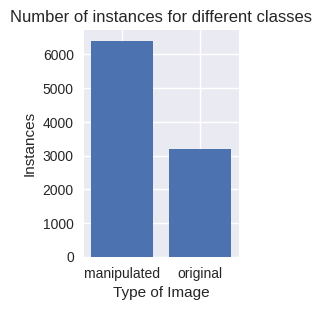

In [ ]:
plt.figure(figsize = (2,3), dpi = 100)
plt.style.use("seaborn")
plt.title("Number of instances for different classes")
plt.bar(x = ["manipulated", "original"], height = [np.count_nonzero(trainY== 1), np.count_nonzero(trainY== 0)])
plt.ylabel("Instances")
plt.xlabel("Type of Image")
print("Ratio of Manipulated Pictures in Dataset: " + str(np.count_nonzero(trainY== 1)  / (np.count_nonzero(trainY== 0)+np.count_nonzero(trainY== 1))))

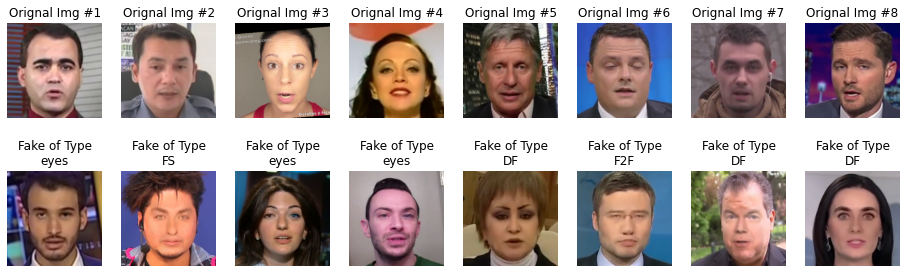

In [86]:
plot_class_examples(8, trainX, trainY, trainType)

In [88]:
os.listdir('./data/train/manipulated')

type_list = []
for path, subdir, files in os.walk('./unzipped_data/data/manipulated/'):
        for name in files:
              if fnmatch.fnmatch(name, "*.png"):
                  type_list.append(name.split("_")[0])

types_of_fakes = list(dict.fromkeys(type_list).keys())
for type_name in types_of_fakes:
  print("Number of Type", type_name, str(type_list.count(type)))

Number of Type mouth 0
Number of Type eyes 0
Number of Type NT 0
Number of Type FS 0
Number of Type F2F 0
Number of Type DF 0


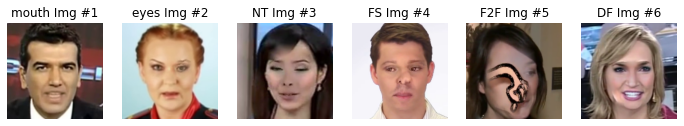

In [89]:
example_list = []
for type_name in types_of_fakes:
  example_list.append(load_color_image('./unzipped_data/data/manipulated/' + type_name +'_1.png', (160,160)))

example_list = np.array(example_list, dtype = 'float32') /255

plot_types(example_list, types_of_fakes)

# Step 3. Building Models

## Step 3.1. Models From The Lecture

#### Image Flattening

In [ ]:
flattend_X = empty((len(X_bw), prod(imagesize)))
for i,img in enumerate(X_bw):
    flattend_X[i,:] = ravel(img)
X_bw = flattend_X
print(X_bw.shape)
print(Y.shape)

NameError: ignored

### Normalization

In [ ]:
# Normalization: sklearn.preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
X_bw = scaler.fit_transform(X_bw)   

### Do Dimenstionality Reduction

In [ ]:
#pca = decomposition.PCA(n_components=50)

svd = decomposition.TruncatedSVD(n_components=250)
#transformed x data
X_svd = svd.fit_transform(trainX)

ValueError: ignored

#### Creating Test Train Split for Reduced Data

In [ ]:
#method used for splitting the data into training and testing partitions
reduced_trainX, reduced_testX, reduced_trainY, reduced_testY = train_test_split(X_svd, Y, test_size=0.2, random_state=77)

In [ ]:
# dict to store evaluation results
predYtest = {}

In [ ]:
clfs = {}
# setup all the parameters and models
exps = {
    #'svm-lin': {
     #   'paramgrid': {'C': logspace(-2,3,5)},
      #  'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [3,4]},
        'clf': svm.SVC(kernel='poly') },
    }

def do_cross_validation_search(exps, trainX, trainY):

  for model_name in exps.keys():
      paramgrid = exps[model_name]['paramgrid']
      estimator = exps[model_name]['clf']

      clf = model_selection.GridSearchCV(estimator, paramgrid, cv=10, n_jobs=-1)
      clf.fit(trainX[0:500], trainY[0:500])
      print("Best cross-validation for {} score is: {:.3f}, with parameters {} ".format(
                                                                              model_name,
                                                                              clf.best_score_, 
                                                                              clf.best_params_))
      #clfs[model_name] = clf
do_cross_validation_search(exps, reduced_trainX, reduced_trainY)

Best cross-validation for svm-rbf score is: 0.652, with parameters {'C': 0.01, 'gamma': 0.0001} 
Best cross-validation for svm-poly score is: 0.658, with parameters {'C': 0.1291549665014884, 'degree': 3} 


----------------------------------------------------------------
Evaluation of SVM Poly on Train-Set
Accuracy Score: 0.67


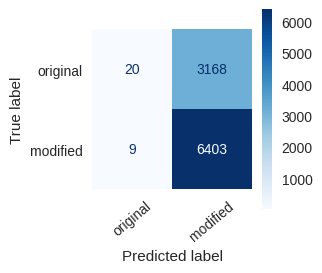

----------------------------------------------------------------
Evaluation of SVM Poly on Test-Set
Accuracy Score: 0.66


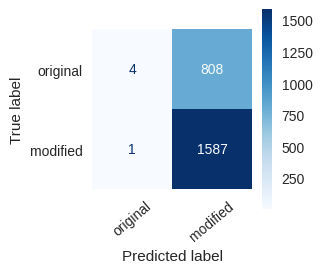

----------------------------------------------------------------


In [ ]:
SVM_poly = svm.SVC(kernel='poly', C = 0.129, degree=3)
SVM_poly.fit(reduced_trainX, reduced_trainY)
evaluate_model(SVM_poly, "SVM Poly", ["original", "modified"],
               reduced_trainX, reduced_testX, reduced_trainY, reduced_testY)

In [ ]:
exps2 = {
    'knn': {
        'paramgrid': {'n_neighbors': arange(2,50,2)},
        'clf': neighbors.KNeighborsClassifier() },
    }
do_cross_validation_search(exps2, reduced_trainX, reduced_trainY)


Best cross-validation for knn score is: 0.646, with parameters {'n_neighbors': 48} 


----------------------------------------------------------------
Evaluation of K Nearest Neighbour on Train-Set
Accuracy Score: 0.67


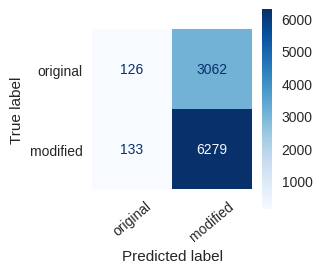

----------------------------------------------------------------
Evaluation of K Nearest Neighbour on Test-Set
Accuracy Score: 0.65


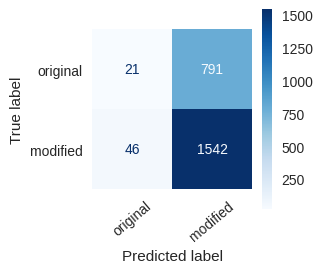

----------------------------------------------------------------


In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=48)
knn.fit(reduced_trainX, reduced_trainY)
evaluate_model(knn, "K Nearest Neighbour", ["original", "modified"], 
               reduced_trainX, reduced_testX, reduced_trainY, reduced_testY)

## Step 3.2. Deep Learning

### 3.2.1 Initial CNN

In [ ]:

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

NameError: ignored

In [ ]:
#del reduced_trainX
#del reduced_testX
#del reduced_trainY
#del reduced_testY
#del X_bw
#del X
#del flattend_X
#del X_svd
#del X_scaled
#del _142
#del _148
#del _171
del X
gc.collect()

84

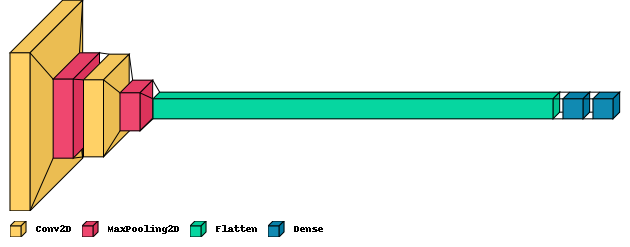

In [ ]:
Simple_RNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

Simple_RNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(Simple_RNN, scale_xy =1, legend=True)

Epoch 1/20
154/154 [==============================] - 96s 620ms/step - loss: 0.7259 - accuracy: 0.6560 - val_loss: 0.6305 - val_accuracy: 0.6771
Epoch 2/20
154/154 [==============================] - 108s 702ms/step - loss: 0.6364 - accuracy: 0.6641 - val_loss: 0.6257 - val_accuracy: 0.6771
Epoch 3/20
154/154 [==============================] - 91s 592ms/step - loss: 0.6295 - accuracy: 0.6621 - val_loss: 0.6257 - val_accuracy: 0.6771
Epoch 4/20
154/154 [==============================] - 88s 574ms/step - loss: 0.6126 - accuracy: 0.6652 - val_loss: 0.6279 - val_accuracy: 0.6448
Epoch 5/20
154/154 [==============================] - 82s 534ms/step - loss: 0.5821 - accuracy: 0.6812 - val_loss: 0.5918 - val_accuracy: 0.6651
Epoch 6/20
154/154 [==============================] - 82s 534ms/step - loss: 0.5403 - accuracy: 0.7048 - val_loss: 0.5909 - val_accuracy: 0.6792
Epoch 7/20
154/154 [==============================] - 82s 531ms/step - loss: 0.4926 - accuracy: 0.7402 - val_loss: 0.6059 - val_a

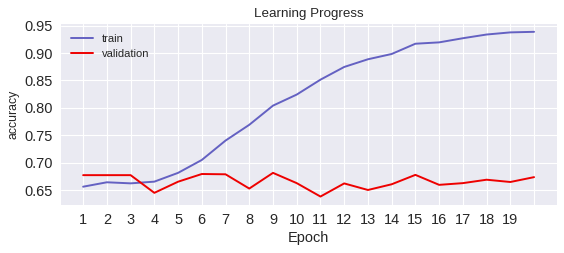

In [ ]:
history = Simple_RNN.fit(trainX, trainY, batch_size=50, epochs=10, validation_data = (valX, valY))
                    # callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=3)])
plot_training(history, 'accuracy', 'val_accuracy')

38/38 [==============================] - 3s 82ms/step


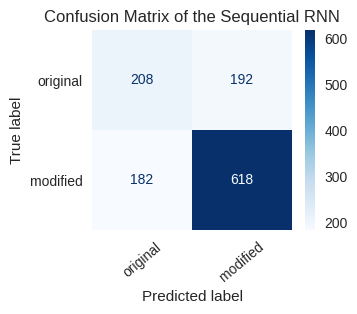

----------------------------------------------------------------


In [ ]:
test_loss = Simple_RNN.evaluate(testX, testY)
predictions = Simple_RNN.predict(testX)
Y_hat = np.argmax(predictions, axis = 1) 
visualize_prediction(testY, Y_hat, "Sequential RNN")

### 3.2.2. CNN with dropout, weights and smaller dense Layer

In [ ]:
print(len(np.where(trainY == 1)[0]))
print(len(np.where(trainY == 0)[0]))

6400
3200


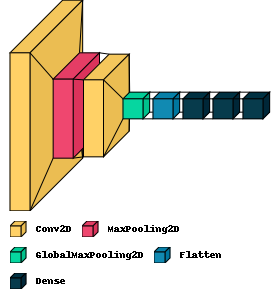

In [ ]:
RNN_with_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(7, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

RNN_with_dropout.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
visualkeras.layered_view(RNN_with_dropout, scale_xy = 1, legend=True)
#tf.keras.utils.plot_model(model, show_dtype=False, dpi = 70)

In [ ]:
history = RNN_with_dropout.fit(trainX, trainY, batch_size=80, epochs=20, validation_data = (valX, valY),
                     callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.01,patience=8)],
                     class_weight={0: 0.7, 1: 0.4})
plot_training(history, 'accuracy', 'val_accuracy')

Epoch 1/20
120/120 [==============================] - 112s 929ms/step - loss: 0.3466 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.4767
Epoch 2/20
120/120 [==============================] - 106s 881ms/step - loss: 0.3466 - accuracy: 0.5069 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 3/20
120/120 [==============================] - 105s 872ms/step - loss: 0.3466 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.4925
Epoch 4/20
120/120 [==============================] - 102s 850ms/step - loss: 0.3466 - accuracy: 0.5053 - val_loss: 0.6931 - val_accuracy: 0.4500
Epoch 5/20
120/120 [==============================] - 103s 857ms/step - loss: 0.3466 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.4408
Epoch 6/20
120/120 [==============================] - 104s 867ms/step - loss: 0.3466 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.4642
Epoch 7/20
 61/120 [==============>...............] - ETA: 49s - loss: 0.3468 - accuracy: 0.5141

KeyboardInterrupt: ignored

----------------------------------------------------------------
Evaluation of Sequential RNN on Test-Set
38/38 [==============================] - 4s 104ms/step
Accuracy Score: 0.67
Recall Score: 1.00
Precision Score: 0.67
AUC: 0.50


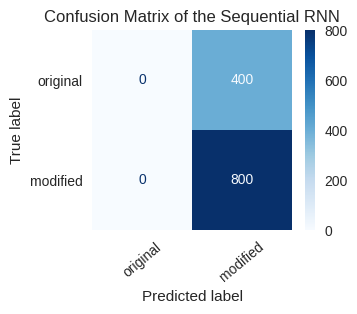

----------------------------------------------------------------
----------------------------------------------------------------


In [ ]:
evaluate_model(RNN_with_dropout, "Sequential RNN", ["original", "manipulated"], testX, testY, skip_train=True)

## 5. Appendix

### 5.1. Upsampling

was finally not used because applying class weights works better and more efficient

In [ ]:
print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))
additional_X_data = trainX[np.where(trainY==0)[0]]
additional_Y_data = trainY[np.where(trainY==0)[0]]
trainY = np.append(trainY, additional_Y_data)
trainX = np.append(trainX, additional_X_data, axis=0)

# shuffle data again
trainX, trainY = shuffle(trainX, trainY)
print(len(trainX))
print(len(trainY))

print(len(np.where(trainY==0)[0]))
print(len(np.where(trainY==1)[0]))

3200
6400
12800
12800
6400
6400
